In [139]:
import common
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Show all columns and rows in a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Max width of a column
pd.set_option("display.max_colwidth", 120)

# Font size in matplotlib
plt.rcParams['font.size'] = 13

# Insertions

The following section shows how to retrieve and plot the data for the experiments related to the insertions.

In [145]:
data_inserts = common.import_gfe("view_inserts").query("omp_threads.isnull() and has_latency == 0 and cluster == 'stones2'").copy() # data from the experiments
data_inserts["compiler_family"] = data_inserts["compiler_family"].fillna("unknown")

Just to see what it looks like:

In [146]:
data_inserts[:5]

,exec_id,cluster,hostname,mode,library,graph,is_directed,compiler_family,compiler,num_threads,omp_threads,num_validation_errors,has_latency,scheduler,build_frequency,build_frequency_secs,num_build_invocations,num_snapshots_created,insertion_time,insertion_time_secs,insertion_time_perc,build_time,build_time_secs,build_time_perc,completion_time,completion_time_secs
0,110,stones2,stones201,standalone,baseline,graph500-26,0,unknown,None,40,NaN,-1,0,static,NaT,NaN,1,0,0 days 10:52:50.805057,39170.805057,100.0,NaT,NaN,0.0,0 days 10:52:50.805057,39170.805057
1,111,stones2,stones202,standalone,stinger,graph500-22,0,unknown,None,40,NaN,-1,0,static,NaT,NaN,1,0,0 days 00:11:03.637758,663.637758,100.0,NaT,NaN,0.0,0 days 00:11:03.637758,663.637758
2,117,stones2,stones212,standalone,stinger,dota-league,0,unknown,None,40,NaN,-1,0,static,NaT,NaN,1,0,0 days 00:07:52.600931,472.600931,100.0,NaT,NaN,0.0,0 days 00:07:52.600931,472.600931
3,118,stones2,stones202,standalone,dummy,graph500-25,0,unknown,None,40,NaN,-1,0,static,NaT,NaN,1,0,0 days 00:00:15.144161,15.144161,100.0,NaT,NaN,0.0,0 days 00:00:15.144161,15.144161
4,120,stones2,stones203,standalone,baseline,graph500-24,0,unknown,None,40,NaN,-1,0,static,NaT,NaN,1,0,0 days 01:45:14.375867,6314.375867,100.0,NaT,NaN,0.0,0 days 01:45:14.375867,6314.375867


### Scalability

Compute the scalability for all experiments and libraries that have been compiled with GCC. Note that,if compiler_family is null or None, then 
these executions refer to the old experiments built with Clang.

In [147]:
scalability = data_inserts.query('compiler_family == "gcc"').groupby(["library", "graph", "num_threads"]) \
    .agg(completion_time=("completion_time_secs", "median"), count=("completion_time_secs", "count"))
scalability.reset_index(level=2, inplace=True)
scalability = pd.merge(scalability, scalability.query("num_threads == 1"), left_index=True, right_index=True) # eventually we'll get it
scalability["scalability"] = scalability["completion_time_y"] / scalability["completion_time_x"] 
scalability = scalability[["num_threads_x", "scalability"]].rename(columns={"num_threads_x":"num_threads"})
scalability = scalability.pivot(columns="num_threads")["scalability"]
scalability[ ~ scalability.index.get_level_values(0).isin(["baseline_seq", "baseline_v2"]) ] # remove sequential adj list

num_threads                            1         2         3         4   \
library                  graph                                            
g1_v4-bw-dv-ignore-build graph500-24  1.0  0.786644  0.705436  0.709901   
                         uniform-24   1.0  0.505034  0.438712  0.423418   
g1_v4-ref-ignore-build   graph500-24  1.0  1.490918  1.708731  1.890241   
                         uniform-24   1.0  1.323740  1.683514  1.739518   
livegraph_ro             graph500-24  1.0  2.087423       NaN  3.783749   
                         uniform-24   1.0  2.089343       NaN  3.714865   
llama6-ref               graph500-24  1.0  3.170336  4.338512  6.273349   
                         uniform-24   1.0  1.675419  1.635378  1.687221   
stinger5-ref             graph500-24  1.0  2.028193       NaN  3.682323   
                         uniform-24   1.0  2.004242       NaN  3.116756   
teseo.9                  graph500-24  1.0  1.712767       NaN  3.104632   
                         uniform-24   1.0  1.670073       NaN  3.053477   

num_threads                                 6          8          12  \
library                  graph                                         
g1_v4-bw-dv-ignore-build graph500-24  0.698513   0.656679   0.600702   
                         uniform-24   0.410442   0.372719   0.343589   
g1_v4-ref-ignore-build   graph500-24  2.197622   2.081522   2.179528   
                         uniform-24   1.906214   1.872264   1.798631   
livegraph_ro             graph500-24  4.840543   5.514654   6.579202   
                         uniform-24   4.674503   5.489735   6.535193   
llama6-ref               graph500-24  9.969071  13.002328  16.930349   
                         uniform-24   1.638556   1.558320   1.470488   
stinger5-ref             graph500-24  5.435679   7.111690  10.292983   
                         uniform-24   4.633995   6.058976   8.844471   
teseo.9                  graph500-24  4.252861   5.369347   7.116709   
                         uniform-24   4.178259   5.227805   6.915274   

num_threads                                  16         20         40  
library                  graph                                         
g1_v4-bw-dv-ignore-build graph500-24   0.586518   0.567591   0.532312  
                         uniform-24    0.331407   0.322131   0.341949  
g1_v4-ref-ignore-build   graph500-24   2.372507   1.972101   1.290662  
                         uniform-24    1.730010   1.607760   1.187668  
livegraph_ro             graph500-24   6.908257   7.009369   6.194685  
                         uniform-24    7.098818   7.125517   6.530407  
llama6-ref               graph500-24  18.470922  18.561004  16.341982  
                         uniform-24    1.394024   1.324059   1.215580  
stinger5-ref             graph500-24  13.257888  16.064697  22.415076  
                         uniform-24   11.250645  13.501849  20.215357  
teseo.9                  graph500-24   8.649229   9.926012  13.099743  
                         uniform-24    8.455224   9.593763  12.839669

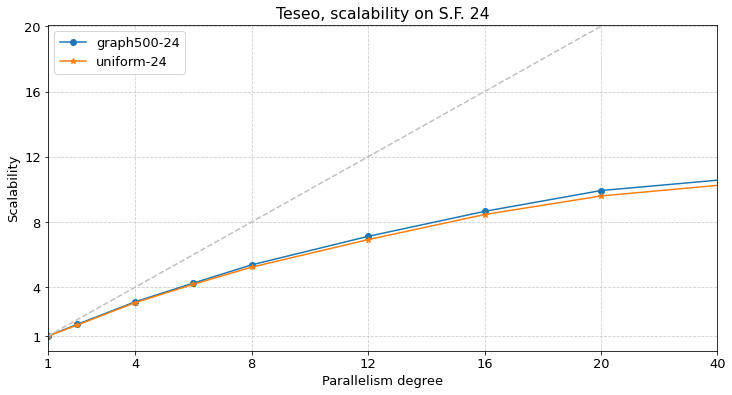

In [248]:
smt = 24 # tick for the Hyper Threading

plt.figure(figsize=(12,6))
plt.title("Teseo, scalability on S.F. 24")
plt.xlim(1, 20)
plt.xlabel("Parallelism degree")
plt.xticks([1, 4, 8, 12, 16, 20, smt], [1, 4, 8, 12, 16, 20, 40])
plt.ylim([0.1, 20.1])
plt.yticks([1, 4, 8, 12, 16, 20])
plt.ylabel("Scalability")
plt.grid(b=True, which='both', color='0.80', linestyle='--')

plt.plot( scalability.loc[("teseo.9", "graph500-24")].dropna(), marker="o" )
plt.plot( scalability.loc[("teseo.9", "uniform-24")].dropna(), marker="*")
plt.plot([1,20], [1,20], "--", color="silver") # diagonal, optimal scalability

plt.legend(["graph500-24", "uniform-24"])

### Throughput

Let's collect the data, according to the best scalability results we obtained. First, for each library, retrieve the list of results we have with some thread on graph500-24:

In [153]:
def fn_join(group): 
    grp = group.unique(); 
    grp.sort()
    return ", ".join(map(str, grp.tolist()))
data_inserts.query("graph == 'graph500-24' & compiler_family == 'gcc'").groupby(["library", "compiler_family"]).agg(num_threads=("num_threads", fn_join))

,,num_threads
library,compiler_family,
baseline_seq,gcc,1
baseline_v2,gcc,"1, 2, 3, 4, 6, 8, 12, 16, 20, 40"
g1_v4-bw-dv-ignore-build,gcc,"1, 2, 3, 4, 6, 8, 12, 16, 20, 40"
g1_v4-bw-sp-ignore-build,gcc,"3, 6, 12"
g1_v4-ref-ignore-build,gcc,"1, 2, 3, 4, 6, 8, 12, 16, 20, 40"
livegraph_ro,gcc,"1, 2, 4, 6, 8, 12, 16, 20, 40"
llama6,gcc,16
llama6-ref,gcc,"1, 2, 3, 4, 6, 8, 12, 16, 20, 40"
stinger5,gcc,"20, 40"


In [229]:
throughput = pd.concat([
    data_inserts.query("compiler_family == 'gcc' and library == 'stinger5-ref' and num_threads == 40").replace("stinger5-ref", "stinger"),
    data_inserts.query("compiler_family == 'gcc' and library == 'llama6-ref' and num_threads == 16 and build_frequency == '00:00:10'").replace("llama6-ref", "llama"),
    data_inserts.query("compiler_family == 'gcc' and library == 'g1_v4-ref-ignore-build' and num_threads == 12").replace('g1_v4-ref-ignore-build', 'graphone'),
    data_inserts.query("compiler_family == 'gcc' and library == 'livegraph_ro' and num_threads == 20").replace("livegraph_ro", "livegraph"),
    data_inserts.query("compiler_family == 'gcc' and library == 'teseo.9' and num_threads == 40").replace("teseo.9", "teseo")
])
throughput = throughput.join( common.edges_per_graph(), on=["graph"])
throughput["throughput"] = throughput["num_edges"] / throughput["completion_time_secs"]
throughput = throughput.groupby(["library", "graph"]).agg(throughput=("throughput", "median"), count=("throughput", "count"))
throughput.loc[("llama", "graph500-26"), ["throughput", "count"]] = np.nan # missing values
throughput.loc[("llama", "uniform-26"), ["throughput", "count"]] = np.nan 
throughput.sort_index(inplace=True)

In [230]:
throughput

throughput  count
library   graph                           
graphone  dota-league  2.424450e+06    5.0
          graph500-22  2.003676e+06    5.0
          graph500-24  2.351804e+06   10.0
          graph500-26  2.440157e+06    5.0
          uniform-22   1.745474e+06    5.0
          uniform-24   1.868658e+06   10.0
          uniform-26   1.964689e+06    5.0
livegraph dota-league  3.247830e+05    5.0
          graph500-22  3.178743e+05    5.0
          graph500-24  3.248569e+05   10.0
          graph500-26  3.169394e+05    5.0
          uniform-22   3.229054e+05    5.0
          uniform-24   3.170492e+05   10.0
          uniform-26   3.161468e+05    5.0
llama     dota-league  3.283794e+05    5.0
          graph500-22  2.928143e+05    5.0
          graph500-24  2.516768e+05   10.0
          graph500-26           NaN    NaN
          uniform-22   2.257523e+05    5.0
          uniform-24   2.243501e+05   10.0
          uniform-26            NaN    NaN
stinger   dota-league  1.968351e+05    5.0
          graph500-22  1.742016e+05    5.0
          graph500-24  8.026602e+04   10.0
          graph500-26  4.013018e+04    5.0
          uniform-22   5.539929e+06    5.0
          uniform-24   4.385855e+06    7.0
          uniform-26   4.793042e+06    5.0
teseo     dota-league  2.037332e+06    5.0
          graph500-22  1.939606e+06    5.0
          graph500-24  2.513198e+06   10.0
          graph500-26  2.443929e+06    5.0
          uniform-22   1.910408e+06    5.0
          uniform-24   2.451743e+06   10.0
          uniform-26   2.416409e+06    5.0

Okay, we're ready to make a plot I think

No handles with labels found to put in legend.


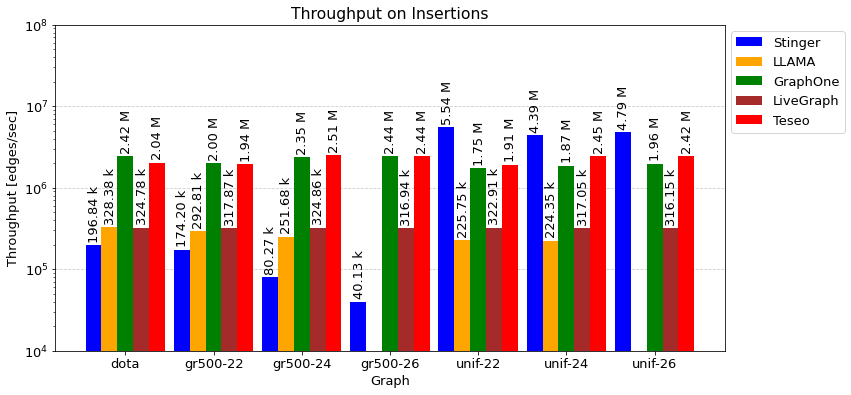

In [247]:
plt.figure(figsize=(12,6))
plt.title("Throughput on Insertions")
plt.yscale("log")
plt.xlabel("Graph")
plt.ylabel("Throughput [edges/sec]")
plt.ylim([10**4, 10**8])
plt.legend().remove() # remove the legend automatically generated

index = np.arange(7) # dota-league, graph500-22, graph500-24, uniform-22, uniform-24
bar_width = 0.18
gap_minor = 0.05

plt.bar(index + gap_minor + 0, throughput.loc["stinger", "throughput"], bar_width, align="edge", color="blue")
plt.bar(index + gap_minor + 1 * bar_width, throughput.loc["llama", "throughput"], bar_width, align="edge", color="orange")
plt.bar(index + gap_minor + 2 * bar_width, throughput.loc["graphone", "throughput"], bar_width, align="edge", color="green")
plt.bar(index + gap_minor + 3 * bar_width, throughput.loc["livegraph", "throughput"], bar_width, align="edge", color="brown")
plt.bar(index + gap_minor + 4 * bar_width, throughput.loc["teseo", "throughput"], bar_width, align="edge", color="red")

plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], ["dota", "gr500-22", "gr500-24", "gr500-26", "unif-22", "unif-24", "unif-26"])

plt.gca().legend(["Stinger", "LLAMA", "GraphOne", "LiveGraph", "Teseo"], bbox_to_anchor=(1, 1), loc="upper left", ncol=1)

# add a label at the top of each bar with its value
for rect in plt.gca().patches:
    value = rect.get_height();
    plt.gca().annotate(common.fmtlabel(value), xy=(rect.get_x() + rect.get_width() / 2 + 0.01, value), xytext=(0,3), textcoords="offset points", ha="center", va="bottom", rotation="90")

plt.gca().set_axisbelow(True)
plt.grid(axis='y', which='major', color='0.80', linestyle='--')